In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

import scipy.signal as sig
import scipy.integrate as sint

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.base import BaseEstimator, RegressorMixin
# import torch
# import torch.nn as nn
# from torch.utils.data import DataLoader, TensorDataset
# import torch.optim as optim

from einops import rearrange, repeat, reduce

# from statsmodels.tsa.stattools import adfuller, kpss
# from statsmodels.tsa.statespace.tools import diff

# torch.manual_seed(123)
np.random.seed(123)

# Echo State Network


- Reservoir Computing framework
- maps input signals to high dimensional computational spaces through the dynamics of fixed non-linear system called reservoir.
- 3 main layers: input, dynamic reservoir, and output layer.
- The input and reservoir weights are non-trainable, only output weights are trainable.

**Echo State property:**
- The echo state property is achieved by spectral radius of reservoir matrix less than unity. $\rho(|W_{res}|) < 1$. If spectral radius is greater than unity, it may lead to unstable and unpredictable behaviour.
- Spectral radius represents magnitude of largest stretch factor of matrix in any direction in vector space.
- Mathematically echo state property, states influence of intial conditions should dissipate exponentially over time leading to stable and predictable behaviour.
- Network can capture relevant behaviour from past without being overwhelmed by noise.
- Echo state will also depend on the factor that X and U are compact sets, where $X \in R^N$ and $U \in R^K$
    - compactness of X warranted by the state activation function.
    - comptactness of U needs to be warranted by using standardizations.
- Yet according to Jaeger, "spectral radius less unity", this is a misconception which everybody is following.

**Equations**

- $x_t = F(x_{t-1}, y_{t-1}, u_t)$
- $x_t = f(W^{in} \cdot u_t +  W^{res} \cdot x_{t-1})$
- $y_t = g(W^{out} \cdot [x_t;u_t])$
- where, 
    - $W^{\text{res}} \in N \times N$ - reservoir weight matrix,
    - $W_{in} \in N \times K$ - input to reservoir weight matrix,
    - $W_{out} \in L \times (N + K)$ - reservoir to output weight matrix,
    - $x_t \in N \times 1$ - state vector at time "t",
    - $u_t \in K \times 1$ - input vector at time "t",
    - $y_t \in L \times 1$ - output vector at time "t",
    - $f()$ is state activation function, can be sigmoid or tanh,
    - $g()$ is output activation function, can be linear or sigmoid,
    - [;] denotes vector concatenation.

- This is Leaky version of the equation: $x_t = (1- \alpha) x_{t-1} + \alpha f(W^{\text{in}} \cdot u_t +  W^{\text{res}} \cdot x_{t-1})$

**Steps: (new version)**


**Training**

1. Initialize the Network.
    - initiate $W^{in}$ as random uniformly distributed matrix. Shape = (N, K)
    - initiate $W^{out}$ as random matrix. Shape = (L, N+K)
    - inititate $W^{res} in a restrictive manner according to Jaeger:
        - initiate a random matrix with all non-negative entries $w_{ij} > 0$
        - Induce sparsity in the matrix using connectivity rate. The connectivity rate($\alpha$) determines the connectivity between neurons. High $\alpha$ is densely connected(weights should be low), Low $\alpha$ is sparsely connected(weights should be high). Usually chosen as $[0.01, 0.05]$.
        - Scale W such that $\rho(W) < 1$. Note: since W is initialized as non-negative, we do not need to do absolute.
        - Change signs of a desired number of entries of W to get negative connections.
2. Calculate state as $x_t = f(W^{in} \cdot u_t +  W^{res} \cdot x_{t-1})$
3. Calculate $W^{out}$ using Regression.


**Testing**


**Steps: (old version)**

If we have a training data $[(u(1), y(1)), (u(2), y(2)), \dots, (u(T), y(T))]$ such that $u(t) \in R^{1 \times K}$ and $y(t) \in R^{1 \times D}$ for T Time steps, then an ESN model can be trainined in the following way:

1. Initialize the network.
    - $W_{res} \in R^{N \times N}$ is a scaled sparse reservoir weight matrix.
        - the size of reservoir(N) determines the time complexity and memory of the reservoir. Optimal values lies inthe interval $[T/10, T/2]$ where T is the length of training sample.
        - The connectivity rate($\alpha$) determines the connectivity between neurons. High $\alpha$ is densely connected(weights should be low), Low $\alpha$ is sparsely connected(weights should be high). Usually chosen as $[0.01, 0.05]$.
        - The sparse weight matrix is scaled as $\frac{\rho}{|\lambda_{max}|}W$ where $\lambda_{max}$ is the largest eigenvalue and  $\rho$ is spectral radius which should be less than 1 to enable Echo state property.
    - $W_{in} \in R^{N \times K}$ is the input to reservoir: input weight matrix.
        - Selected from uniform distribution of [$- scale_{in}, scale_{in}$]
    - $W_{out} \in R^{D \times N}$ the reservoir to output: output weight matrix.
    - $W_{back} \in R^{N \times D}$ the output to reservior: feedback weight matrix. (optional)
    - washout Time step($I_0$) <i style="color: yellow;">(What is this??)</i>
        - Time period which we need to ignore until randomize values start to converge.


2. Update the reservoir states using the below equation. This will lead to state for each time step, thus having T reservoir states.

\begin{equation}
x(t) = f\left(W_{\text{in}} \cdot u(t) +  W_{\text{res}} \cdot x(t-1) + W_{\text{back}} \cdot y(t-1) \right)
\end{equation}

Below equation is with a leaky parameter.
    
\begin{aligned}
x(t) = (1- \alpha)x(t-1) + \alpha f\left(W_{\text{in}} \cdot u(t) +  W_{\text{res}} \cdot x(t-1) + W_{\text{back}} \cdot y(t-1) \right)
\end{aligned}

3. Update the $W_{out}$ using reservoir internal states $X \in R^{N \times T}$ and target vector $Y \in R^{D \times T}$.
    - in offline method, this equation can be solved using Tikhnov Regularization/Ridge Regression.
    - in online method, this can be solve using ordinary least squares(OLS).

\begin{aligned}

W_{\text{out}} = Y \cdot X^{-1}
\end{aligned}


4. For Prediction, use below equation.


$\hat{y}(t) = W_{\text{out}} \cdot x(t)$

In [2]:
## Inducing sparsity in matrix: 
## Connectivity rate = 0.0 makes all matrix values 0 and 
## Connectivity rate = 1.0 makes no values zero.
## 
mat1 = np.random.rand(5,5)
mat1[np.random.rand(*mat1.shape) > 0.0] = 0
mat1

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [3]:
x_t = np.random.randn(5, 1)
u_t = np.random.randn(10,1)
concat = np.concatenate((x_t, u_t))
concat.shape

(15, 1)

In [4]:
X = np.random.randn(1,1)
X = X.reshape(-1)
X.shape

(1,)

1> 
y = x(t+1)

x = x(t)
W_out per time point.


2> learn the all states possible
then update W_out per epoch

3> concat  loss of x(t)

ESN1 - output calculate loss 
ESN2 - loss of output - ground truth
Now minimize alha ESN 1 and beta ESN2, minimize this loss. alpha and beta will be hyperparameter.

combined loss might make difficult optimization

gradual loss --> Explor this idea.

### Augmented Data with stationarity

(400,)
(100,)


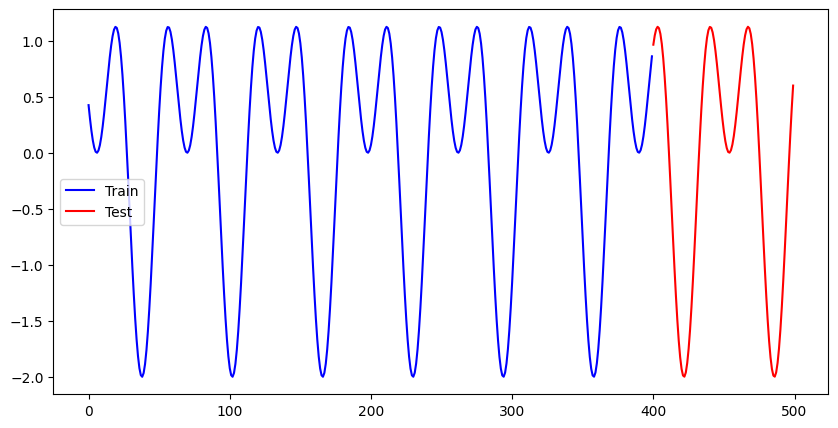

In [5]:
# Sinusoidal Curves - Seasonal stationary data.
def func1(x):
    return np.sin(x) + np.cos(2*x)


points = np.linspace(1,50, 500)
aug_series1 = func1(points)

## Train and Test Splitting of Time Series Data
X = aug_series1
X_train, X_test = train_test_split(X, test_size=0.2, shuffle=False)
print(X_train.shape)
print(X_test.shape)

plt.figure(figsize=(10,5))
plt.plot(np.arange(len(X_train)), X_train, c='blue', label='Train')
plt.plot(np.arange(len(X_train), len(X_train) + len(X_test)), X_test, c="red", label='Test')
# plt.plot(X_test, c='red')
plt.legend()
plt.show()


In [6]:
X_train = rearrange(X_train, 'r -> r 1')
X_test = rearrange(X_test, 'r -> r 1')

sc = MinMaxScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

# Strategy 1> 

**Train on all time steps, and do backward once per epoch.**


**Observationss**
- Theroetically, this should need more epochs than doing per time step. <i style="color:red">(Incorrect)</i>
- We do not need epochs. It will calculate same weight in each epoch. 

**Standardized Results**

| Parameters | RMSE | MAE | MAPE | 
|--|--|--|--|
|size=10, spectral_radius=0.8, connectivity_rate=0.8 | 0.068 | 0.065| 5.16|
|size=20, spectral_radius=0.8, connectivity_rate=0.8 | 0.024 | 0.021| 1.49|
|size=50, spectral_radius=0.8, connectivity_rate=0.8 | 0.094 | 0.093| 6.45|
|size=50, spectral_radius=0.3, connectivity_rate=0.5 | 0.014 | 0.011| 0.06|
|size=100, spectral_radius=0.3, connectivity_rate=0.8 | 0.025 | 0.023| 1.90|

**Scaled Results**

| Parameters | RMSE | MAE | MAPE | 
|--|--|--|--|
|size=10, spectral_radius=0.8, connectivity_rate=0.8 | 0.21 | 0.20| 0.79|
|size=20, spectral_radius=0.8, connectivity_rate=0.8 | 0.07 | 0.06| 0.30|
|size=50, spectral_radius=0.3, connectivity_rate=0.5 | 0.04 | 0.03| 0.15|
|size=100, spectral_radius=0.3, connectivity_rate=0.8 | 0.079 | 0.074| 0.31|

This shows:
- if neurons are increased, spectral radius should be lowered to reduce size of weights and connectivity rate should be more sparse.

In [7]:
class ESN(BaseEstimator, RegressorMixin):

    def __init__(self, reservoir_size=100, input_size=1, output_size=1,  spectral_radius=1.0, connectivity_rate=1.0, epochs=1, lr=0.01, leaky_parameter=1.0, washout=1):
        self.reservoir_size = reservoir_size
        self.input_size = input_size
        self.epochs = epochs
        self.lr = lr
        self.washout = washout


        self.state = np.zeros((self.reservoir_size, 1))
        self.W_in = np.random.randn(reservoir_size, input_size) * 2 - 1
        
        self.W_out = None

        ## Initialize a random matrix and induce sparsity.
        self.W_res = np.random.randn(reservoir_size, reservoir_size)
        self.W_res[np.random.rand(*self.W_res.shape) > connectivity_rate] = 0

        ##  Scale the matrix based on user defined spectral radius.
        current_spectral_radius = np.max(np.abs(np.linalg.eigvals(self.W_res)))
        self.W_res = self.W_res * (spectral_radius / current_spectral_radius)


    def fit(self, X_train, y_train):
        
        ## Epochs are useless. Keep it as 1 always.
        for _ in range(self.epochs): 

            ## Reset states.
            concat_matrix = np.zeros((self.input_size + self.reservoir_size, 1))
            # self.state = np.zeros((self.reservoir_size, 1))

            ## Calculate state of reservoirs per time step
            for i in range(X_train.shape[0]-1):
                input = X_train[i].reshape(-1,1)
                input_product = self.W_in@input
                state_product = self.W_res@self.state
                self.state = np.tanh(input_product + state_product)
                concat_matrix= np.hstack((concat_matrix, np.concatenate((self.state, input))))
            

            ## Update W_out
            mat1 = concat_matrix.T[self.washout:,:]
            ridge_regressor= Ridge(alpha=self.lr)
            ridge_regressor.fit(mat1, y_train[self.washout:,:])
            self.W_out = ridge_regressor.coef_
            # self.W_out = np.dot(np.linalg.pinv(mat1), y_train)


    def predict(self, X_test):
            input_product = self.W_in@X_test
            state_product = self.W_res@self.state
            self.state = np.tanh(input_product + state_product)
            concat_matrix= np.concatenate((self.state, X_test))
            pred =  self.W_out@concat_matrix
            return pred

In [8]:
esn = ESN(reservoir_size=100, input_size=1, output_size=1, spectral_radius=0.1, connectivity_rate=0.5, washout=50)

esn.fit(X_train_std, X_train_std)

In [9]:
y_pred = []

for i in range(len(X_test_std)-1):
    pred = esn.predict(X_test_std[i].reshape(-1,1))
    y_pred.append(pred)

predictions = np.array(y_pred).reshape(-1, 1)
test_values= X_test_std[1:]

print(np.sqrt(mean_squared_error(test_values, predictions)))
print(mean_absolute_error(test_values, predictions))
print(mean_absolute_percentage_error(test_values, predictions))

0.021021233081190333
0.0184083224039238
1.02516685807743


In [10]:
predictions_scaled = sc.inverse_transform(predictions)
print(np.sqrt(mean_squared_error(predictions_scaled, X_test[1:])))
print(mean_absolute_error(predictions_scaled, X_test[1:]))
print(mean_absolute_percentage_error(predictions_scaled, X_test[1:]))

0.06566185729366512
0.057500177750456634
0.5390423384169105


## Enabling Grid Search Functionality

In [11]:
param_grid = {'reservoir_size': [10, 20, 50, 100],
              'spectral_radius': [0.1, 0.2, 0.5, 0.7, 0.9, 1.0],
            #   'connectivity_rate': [0.1, 0.2, 0.5, 0.7, 0.9, 1.0],
              'leaky_parameter': [0.0, 0.2, 0.5, 0.8, 1.0]}

grid = GridSearchCV(ESN(input_size=1, output_size=1), param_grid=param_grid, refit=True, cv=3, scoring="neg_root_mean_squared_error")


grid.fit(X_train_std, X_train_std)

AttributeError: 'ESN' object has no attribute 'connectivity_rate'